In [1]:
#https://www.ncei.noaa.gov/data/global-hourly/access/2019/ [QCLCD]
#Times are in UTC
#################################################################################################
#QUALITY-CHECKS [QC]
# 0 = Passed gross limits check
# 1 = Passed all quality control checks
# 2 = Suspect
# 3 = Erroneous
# 4 = Passed gross limits check, data originate from an NCEI data source
# 5 = Passed all quality control checks, data originate from an NCEI data source
# 6 = Suspect, data originate from an NCEI data source
# 7 = Erroneous, data originate from an NCEI data source
# 9 = Passed gross limits check if element is present
# A = Data value flagged as suspect, but accepted as a good value
# C = Temperature and dew point received from Automated Weather Observing System (AWOS) are reported in
#     whole degrees Celsius. Automated QC flags these values, but they are accepted as valid.
# I = Data value not originally in data, but inserted by validator
# M = Manual changes made to value based on information provided by NWS or FAA
# P = Data value not originally flagged as suspect, but replaced by validator
# R = Data value replaced with value computed by NCEI software
# U = Data value replaced with edited value 
#0,1,4,5,9
#################################################################################################
#VISIBILITY-OBSERVATION variability code [VVVVVV-Type]
#The code that denotes whether or not the reported visibility is variable.
#DOM: A specific domain comprised of the characters in the ASCII character set.
#N = Not variable
#V = Variable
#9 = Missing
#VVVVVV,QC-VVVVVV,Variability,QC-Variability
#################################################################################################
#WIND-OBSERVATION type code [WND-Type]
#The code that denotes the character of the WIND-OBSERVATION.
#DOM: A specific domain comprised of the characters in the ASCII character set.
#A = Abridged Beaufort
#B = Beaufort
#C = Calm
#H = 5-Minute Average Speed
#N = Normal
#R = 60-Minute Average Speed
#Q = Squall
#T = 180 Minute Average Speed
#V = Variable
#9 = Missing
#NOTE: If a value of 9 appears with a wind speed of 0000, this indicates calm winds.
#################################################################################################
#################################################################################################
#STATION                            = nnnnnnNNNNN                                      = n == USAF identifier (7099999 == none) | N == WBAN identifier
#DATE                               = "YYYY-MM-DDTHH:MM:SS"
#LATITUDE                           = deg. north [+]
#LONGITUDE                          = deg. west  [-]
#TMP [sfc. temperature]             = TTTT,TTTT-QC                                     = celsius(factor=10),categorical
#DEW [sfc. dew point]               = TTTT,TTTT-QC                                     = celsius(factor=10),categorical
#WND [sfc. wnd-dir. & wnd-spd.]     = DDD,DDD-QC,WND-Type,WWWW,WWWW-QC                 = degrees,categorical,categorical,meters-per-second,categorical
#OC1 [sfc. gust]                    = GGGG,GGGG-GC                                     = meters,categorical
#MA1 [altimiter & stat. pres.]      = AAAAA,AAAAA-QC,PPPPP,PPPPP-QC                    = hectopascals(factor=10),categorical,hectopascals(factor=10),categorical 
#VIS [sfc. visibility]              = VVVVVV,VVVVVV-QC,VVVVVV-Type.,VVVVVV-Type.-QC    = meters,categorical,categorical,categorical
#SLP [sea level pressure]           = PPPPP,PPPPP-QC                                   = hectopascals(factor=10),categorical 
#AA1 [liquid water equivalent]      = DD,PPPP,Trace-QC,PPPP-QC [1-3-6 hourly]          = hours,milimeters(factor=10),categorical
#AA2 [liquid water equivalent]      = DD,PPPP,Trace-QC,PPPP-QC [daily]                 = hours,milimeters(factor=10),categorical
#"STATION","DATE","TMP","DEW","WND","OC1","MA1","VIS","SLP","AA1","AA2"
#STATION,DATETIME,DATETIME-VALID,TDIFF,T2,Td,Tw,RH,Q,WS,WD,WG,SLP,SP,LWE
#################################################################################################
#DERIVED
#RH               = e/es * 100% (relative humidity)
##### e(celsius)  = 6.11*10**((7.5*Td)/(237.3+Td)) (vapor pressure)
##### es(celsius) = 6.11*10**((7.5*T)/(237.3+T)) (saturated vapor pressure)
#https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf [RH]
#TW(Celsius,%)    = T * atan(0.151977*(RH+8.313659)**0.5) + atan(T+RH) - atan(RH-1.676331) + 0.00391838*atan(RH)**1.5 * atan(0.023101*RH) - 4.686035 (wet-bulb temperature [Stull 2011])
#q                = rv/(1+rv) (specific humidity)
##### rv          = (0.622*e)/(P+e) (mixing ratio)
#################################################################################################

In [160]:
# Assuming you have your Analysis stations
from metar import Metar
import matplotlib        as mpl
from itertools import compress
from datetime import timedelta
import glob
import shutil
import os
from datetime import datetime
import pytaf
import numpy.matlib
import dateutil.parser
import numpy as np
import pandas as pd
from math import atan
from os import listdir
import sys
import requests
#
WS_TH = 2*0.514444
WG_TH = 16*0.514444
##########################################################################################
# Are stations in or out of boundary
##########################################################################################
def Shrink_Data_to_Domain(XYZ):
    Polygon_Log = np.zeros((len(XYZ),1))
    for i in range(len(XYZ)):
        pt = (float(XYZ[i,2]),float(XYZ[i,1]))
        if Point(pt).within(shape(boundary)): # make a point and see if it's in the polygon
            Polygon_Log[i,0] = 1
    XYZ = np.asarray(list(compress(XYZ,Polygon_Log==1)))
    return(XYZ)

##########################################################################################
# Determine string of date as YYYYMMDDHH
##########################################################################################
def YYYYMMDDHH_string(Datetime_Value):
    if Datetime_Value.month>9:
        Month_str = str(Datetime_Value.month)
    else:
        Month_str = "0"+str(Datetime_Value.month)   
    if Datetime_Value.day>9:
        Day_str = str(Datetime_Value.day)
    else:
        Day_str = "0"+str(Datetime_Value.day)
    if Datetime_Value.hour>9:
        Hour_str = str(Datetime_Value.hour)
    else:
        Hour_str = "0"+str(Datetime_Value.hour)
    return (str(Datetime_Value.year)+Month_str+Day_str+Hour_str)

##########################################################################################
# Round the observation's time to determine hourly observations
##########################################################################################
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

##########################################################################################
# Data conversions
##########################################################################################
def Temperature_Delim_Calc_C(Temperature_Cell): #TEMPERATURE
    T2_C = np.nan
    if len(Temperature_Cell["TMP"])>0: # SFC TEMPERATURE
        Temp_Obs = Temperature_Cell["TMP"].split(',')
        if Temp_Obs[1] == '0' or Temp_Obs[1] == '1' or Temp_Obs[1] == '4' or Temp_Obs[1] == '5' \
        or Temp_Obs[1] == '9' or Temp_Obs[1].isalpha():
            T2_C = float(Temp_Obs[0])/10 #celsius
            if T2_C > 100:
                T2_C = np.nan
    return (T2_C)

def DewPoint_Delim_Calc_C(DewPoint_Cell): #DEW POINT TEMPERATURE
    DP2_C = np.nan
    if len(DewPoint_Cell["DEW"])>0:
        DP_Obs = DewPoint_Cell["DEW"].split(',')
        if DP_Obs[1] == '0' or DP_Obs[1] == '1' or DP_Obs[1] == '4' or DP_Obs[1] == '5' \
        or DP_Obs[1] == '9' or DP_Obs[1].isalpha():
            DP2_C = float(DP_Obs[0])/10
            if DP2_C > 100:
                DP2_C = np.nan
    return (DP2_C)

def WindGust_Delim_Calc_ms(WindGust_Cell): #WIND GUST
    WG_ms = np.nan
    if len(WindGust_Cell["OC1"])>0: 
        WG_Obs = WindGust_Cell["OC1"].split(',')
        if WG_Obs[1] == '0' or WG_Obs[1] == '1' or WG_Obs[1] == '4' or WG_Obs[1] == '5' \
        or WG_Obs[1] == '9' or WG_Obs[1].isalpha():
            WG_ms = float(WG_Obs[0])/10 #celsius
            if WG_ms > 100:
                WG_ms = np.nan
            elif WG_ms<WG_TH:
                WG_ms = np.nan
    return (WG_ms)

def WindSp_WindDir_Calc_ms_deg(Wind_Cell): #WIND SPEED | WIND DIRECTION
    wsms_wddeg = np.nan,np.nan
    if len(Wind_Cell["WND"])>0:
        Wind_Obs = Wind_Cell["WND"].split(',')
        if Wind_Obs[1] == '0' or Wind_Obs[1] == '1' or Wind_Obs[1] == '4' or Wind_Obs[1] == '5' \
        or Wind_Obs[1] == '9' or Wind_Obs[1].isalpha():
            if Wind_Obs[2] == "N":
                wsms_wddeg = float(Wind_Obs[3])/10,float(Wind_Obs[0]) #degrees 
            elif Wind_Obs[2] == "C" or Wind_Obs[2] == '9':
                wsms_wddeg = np.nan,np.nan
        if wsms_wddeg[0]<WS_TH:
            wsms_wddeg = np.nan,np.nan
        elif wsms_wddeg[0]>100:
            wsms_wddeg = np.nan,np.nan
        elif wsms_wddeg[1]>361:
            wsms_wddeg = np.nan,np.nan
    return (wsms_wddeg) 

def StationPres_Alt_Calc_hpa(Pressure_Cell): #STATION PRESSURE
    SP_hpa = np.nan
    if len(Pressure_Cell["MA1"])>0:
        Pressure = Pressure_Cell["MA1"].split(',')
        if Pressure[3] == '0' or Pressure[3] == '1' or Pressure[3] == '4' or Pressure[3] == '5' \
        or Pressure[3] == '9' or Pressure[3].isalpha():
            SP_hpa = (float(Pressure[2])/10)*100 
            if SP_hpa > 200000:
                SP_hpa = np.nan
    return (SP_hpa)    

def Precipitation_Type(METAR_Remark_Cell):
    Parsed_METAR = METAR_Remark_Cell['REM']
    if "METAR" in Parsed_METAR:
        Parsed_METAR = Parsed_METAR[Parsed_METAR.index('METAR'):]
        try:
            TAF_report = pytaf.TAF(Parsed_METAR)
            taskbarskies = True
        except:
            taskbarskies = False
            pass # doing nothing on exception              
        if taskbarskies == True:
            TAF_report = pytaf.TAF(Parsed_METAR)
            decoder    = pytaf.Decoder(TAF_report)
            TAF_report = decoder.decode_taf()
            TAF_report = str(np.asarray(TAF_report))
            TAF_report = TAF_report.split('\n')
            Type = []
            for i in range(len(TAF_report)):
                if "Weather:" in TAF_report[i]:
                    Type = str(TAF_report[i])
                    break
            if len(Type)>0:
                Type_str = str(Type.replace("Weather:","")).strip()
                if "/" in Type:
                    Type_str = Type_str.split('/')
                    Type_str = Type_str[0].strip()
                else:
                    Type_str = Type_str.strip()
            else:
                Type_str = 'Fair_wx'
        else:
            Type_str = 'Failed_Parsed'
    else:
        Type_str = 'Not_Parsed'
    return(Type_str)

def Visibility_meters(Visibility_Cell):
    VIS_m = np.nan
    if len(Visibility_Cell["VIS"])>0:
        Visibility = Visibility_Cell["VIS"].split(',')
        if Visibility[1] == '0' or Visibility[1] == '1' or Visibility[1] == '4' or Visibility[1] == '5' \
        or Visibility[1] == '9' or Visibility[1].isalpha():
            VIS_m = float(Visibility[0])
            if VIS_m == 999999:
                VIS_m = np.nan
    return (VIS_m)    

##########################################################################################
# CALCULATIONS
##########################################################################################

def Specific_Humidity(Dew_Temperature_C,Station_Pressure_pat):
    e = 6.11*10**((7.5*Dew_Temperature_C)/(237.3+Dew_Temperature_C))
    rv = (0.622*e)/(Station_Pressure_pat+e)
    sh = rv/(1+rv)*100
    return (sh)

def Relative_Humidity(Temperature_C,Dew_Temperature_C):
    e  = 6.11*10**((7.5*Dew_Temperature_C)/(237.3+Dew_Temperature_C))
    es = 6.11*10**((7.5*Temperature_C)/(237.3+Temperature_C))
    RH = (e/es) * 100
    return (RH)

def Wet_Bulb_Stull(Temperature_C,RH_perc):
    C1 = 0.151977 #Stull Tw
    C2 = 8.313659 #Stull Tw 
    C3 = 1.676331 #Stull Tw
    C4 = 0.00391838 #Stull Tw
    C5 = 0.023101 #Stull Tw
    C6 = 4.686035 #Stull Tw
    tw = Temperature_C*atan(C1*(RH_perc+C2)**0.5)+atan(Temperature_C+RH_perc)-atan(RH_perc-C3)+C4*((RH_perc)**1.5)*atan(C5*RH_perc)-C6
    return (tw)

##########################################################################################
# COMPILING CSV FILES INTO AN EVENT FILE
##########################################################################################
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

##########################################################################################
# WILL IT FINISH SOON???
##########################################################################################
def progressBar(value, endvalue, bar_length=20):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
###
### Plotting
###
nVars     = 7
nDomains  = 3
fontszt   = 8
titlesize = 12
c_min     = 1
c_max     = 100
RTT       = -25
Titles    = ["Station Pressure [mb]","2-m Temperature [C]", "2-m Dew Point Temp. [C]", "2-m Wet-bulb Temp. [C]", 
             "2-m Relative Humidity [%]","2-m Specific Humidity [kg/kg]","10-m Wind Speed [m/s]"]
XYMIN     = [900 ,-10,-10,-10,  0,0.0015 ,0]
XYMAX     = [1040, 30, 30, 30,100,0.0200 ,40]
INCR      = [1,   0.5,0.5,0.5,1  ,0.0001 ,0.5]
Y_label   = "Pred."
X_label   = "Obs."
Obs_Array = ['PSFC_o','T2_o','Td_o','WB_o','RH_o','SH_o','WS_o']
WRF_Array = ['PSFC'  ,'T2'  ,'Td'  ,'Tw'  ,'RH'  ,'SH'  ,'WS_10']
Domain    = ['d01','d02','d03']
###
def Heat_bin_plots(MINXY,MAXXY,INCR,Predictor,Observed,c_min,c_max):
    bins    = (np.arange(MINXY,MAXXY+INCR,step=INCR),np.arange(MINXY,MAXXY+INCR,step=INCR))
    ### 
    X = Observed
    Y = Predictor
    var_nan = np.transpose(np.vstack((X,Y)))
    var = var_nan[~np.isnan(var_nan).any(axis=1)]
    X = var[:,0]
    Y = var[:,1] 
    img = plt.hist2d(X, Y,norm=mpl.colors.LogNorm(), bins=bins, cmin = 1,cmap=plt.cm.jet)
    plt.plot(line_x, line_x,color='black',linewidth=LWIDTH);
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
    line_y = slope*line_x + intercept
    plt.plot(line_x, line_y,color='gray',linestyle='--',linewidth=LWIDTH)
    plt.text(0.08, 0.92,"Cor. C. = "+str(round(r_value,2))+'\n' "y = "+str(round(slope,2))+"*x"+" + "+str(round(intercept,2)), va='center', transform=ax.transAxes, fontsize = 10, color='black',
            bbox=dict(facecolor='white', alpha=trp,edgecolor='white', boxstyle='square,pad=0.20'))
    plt.grid(b=None, which='major', axis='both',linestyle=':')
    ax.tick_params(axis='both',direction='in')
    plt.xticks(rotation=RTT)
    ax.set_xlim([MINXY,MAXXY])
    ax.set_ylim([MINXY,MAXXY])
    plt.clim(c_min,c_max)
# Dumby data for colorbar
x = [i for i in range(20)]
dumby_img = plt.hexbin(x, x,cmap='jet', vmin=1, vmax=c_max,mincnt=1,norm=mpl.colors.LogNorm())
plt.close(fig=None)

In [183]:
#https://www.ncei.noaa.gov/data/global-hourly/access/
#https://www.ncei.noaa.gov/data/global-hourly/doc/CSV_HELP.pdf
#https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf
#https://www.ncdc.noaa.gov/isd
######################################################################################
###SIMULATION CONSTANTS
######################################################################################
Time_diff_limit_mins     = 30 #Ant obs-valid time > Time_diff_limit_mins will be excluded
QCLCD_dir                = r'https://www.ncei.noaa.gov/data/global-hourly/access/'
Events_List              = pd.read_csv(r'C:/Users/Mike/Desktop/QCLCD/Events.csv')
QCLCD_station_csv        = pd.read_csv(r'C:/Users/Mike/Desktop/Offshore/Case_Studies/d01.csv')
#QCLCD_station_csv.rename(columns={0:'File_Name',1:'Lat',2:'Lon'}, inplace=True)
Spinup                   = int(12)

for x in range(1,len(Events_List)): # Event loop
    ######################################################################################
    ###START TIME AND END TIME FOR OBSERVATION WEBSCRAPE
    ######################################################################################
    Initialization_Year      = Events_List['Start_Year'][x]
    Initialization_Month     = Events_List['Start_Month'][x]
    Initialization_Day       = Events_List['Start_Day'][x]
    Initialization_Hour      = Events_List['Start_Hour'][x]
    Initialization_Durration = Events_List['Durration'][x]
    ### Obtain the Start and End Times of the Simulation
    Datetime_Initialization  = datetime(Initialization_Year, Initialization_Month, Initialization_Day,Initialization_Hour,0,0)+timedelta(hours=Spinup)
    print(Datetime_Initialization)
    Datetime_Termination     = Datetime_Initialization+timedelta(hours=int(Initialization_Durration))
    ### End times
    if Datetime_Termination.month>9:
         Month_str = str(Datetime_Termination.month)
    else:
        Month_str = "0"+str(Datetime_Termination.month)   
    if Datetime_Termination.day>9:
        Day_str = str(Datetime_Termination.day)
    else:
        Day_str = "0"+str(Datetime_Termination.day)
    str_end = str(Datetime_Termination.year)+Month_str+Day_str
    ### Start times
    if Datetime_Initialization.month>9:
        Month_str = str(Datetime_Initialization.month)
    else:
        Month_str = "0"+str(Datetime_Initialization.month)   
    if Datetime_Initialization.day>9:
        Day_str = str(Datetime_Initialization.day)
    else:
        Day_str = "0"+str(Datetime_Initialization.day)
    str_begin = str(Datetime_Initialization.year)+Month_str+Day_str
    ######################################################################################
    ###STATION WEBSCRAPING BASED ON DATE
    ######################################################################################    
    for y in range(len(QCLCD_station_csv)): #Station loop
        url = QCLCD_dir+str(Initialization_Year)+"/"+str(QCLCD_station_csv["File_Name"][y])+".csv"
        Check_station_metadata = requests.head(url)
        Check_station_metadata = Check_station_metadata.headers
        Check_station_metadata = pd.DataFrame.from_dict(Check_station_metadata)
        Check_log = np.sum(Check_station_metadata == "ETag")
        if Check_log[0]>0: #Is data for 'y' station available on said date?
            Data_Server   = str_begin+"_"+str_end+"_"+str(QCLCD_station_csv["File_Name"][y])
            QCLCD_Station = str(QCLCD_station_csv["File_Name"][y])
            #print("Downloading Data for Station: "+QCLCD_Station)
            #########################################################################################################
            ### ***SHRINK DATA*** ###
            #########################################################################################################
            # variables for analysis (shrink dataframe)
            Compressed_QCLCD = pd.read_csv(QCLCD_dir+"/"+str(Datetime_Initialization.year)+"/"+QCLCD_Station+".csv",dtype=object)
            # time-window for analysis (shrink dataframe)
            start_time       = Datetime_Initialization
            start_end        = Datetime_Termination
            # datetime of observation
            datetime_station = np.expand_dims(Compressed_QCLCD["DATE"].to_numpy(dtype=str),1)
            # determine if the observation falls within the time-window for analysis
            row_logical      = np.zeros((len(datetime_station), 1))
            for i in range(len(row_logical)): #Is the date within the time of analysis?
                if start_time <= dateutil.parser.parse(datetime_station[i,0]) <= start_end:
                    row_logical[i,0] = True   
            # add boolean results back into the original dataframe [did the observation fall w/in the analysis time-window]
            Compressed_QCLCD['Date_Boolean'] = pd.DataFrame(row_logical)
            # remove 'false' boolean results
            Compressed_QCLCD                 = Compressed_QCLCD[Compressed_QCLCD.Date_Boolean != 0]
            # replace 'nan' values with empty strings for data-processing
            Compressed_QCLCD                 = Compressed_QCLCD.replace(np.nan, '', regex=True).reset_index()
            # create an array filled with the station's wmo/wban identifiers
            Stations                         = np.matlib.repmat(QCLCD_Station, len(Compressed_QCLCD), 1)
            #########################################################################################################
            ### ***DETERMINE TIMES & T-DIFF*** ###
            #########################################################################################################
            # preallocate arrays to determine hourly observations (comparing vs. NWP hourly output)
            d = len(Compressed_QCLCD)
            Time_Matrix = np.empty([d,3], dtype=object)
            time_valid  = np.empty([d,1], dtype=object)
            Date_times  = np.empty([d,1], dtype=object)
            # determine the time difference (minutes) b/n the nearest hour vs. the observation's time,
            # return a matrix of the observation's rounded YYYY, MM, DD, HH, and TDIFF 
            for i in range(d):
                Date_times[i,0]     = dateutil.parser.parse(Compressed_QCLCD["DATE"][i])
                time_round          = hour_rounder(Date_times[i,0])
                time_valid[i,0]     = datetime.strptime(str(Date_times[i,0]), '%Y-%m-%d %H:%M:%S')
                tdiff               = abs(time_valid[i,0]-time_round)
                tdiff               = int(tdiff.seconds/60)
                Time_Matrix[i,:]    = Compressed_QCLCD["DATE"][i],YYYYMMDDHH_string(time_round),str(tdiff)
            Dates       = np.unique(Time_Matrix[:,1])
            row_logical = np.zeros((len(Time_Matrix[:,1]), 1))
            for z in range(len(Dates)):
                Log_Key = np.expand_dims(Time_Matrix[:,1]==Dates[z],1)
                if len(Log_Key>0):
                    row             = [i for i, j in enumerate(Log_Key) if j]
                    Key_Time_Matrix = Time_Matrix[row]
                    row_check       = np.argmin(np.array(Key_Time_Matrix[:,2], dtype=np.float), axis=None, out=None)
                    row             = row[row_check]
                    row_logical[row,0] = 1
            Compressed_QCLCD = pd.concat([Compressed_QCLCD, pd.DataFrame(Time_Matrix)], axis=1)
            if len(Compressed_QCLCD)>0:
                Compressed_QCLCD['Hourly_Boolean'] = pd.DataFrame(row_logical)
                Compressed_QCLCD = Compressed_QCLCD.rename(columns={0: "Date_Time_Obs", 1: "Date_Valid_Hour",2:"Time_Diff_mins"})
                Compressed_QCLCD = Compressed_QCLCD[Compressed_QCLCD.Hourly_Boolean != 0].reset_index()
                Compressed_QCLCD = Compressed_QCLCD[pd.to_numeric(Compressed_QCLCD['Time_Diff_mins'])<Time_diff_limit_mins]
                #########################################################################################################
                ### ***ADD MANDATORY COLUMNS IF NOT AVAILABLE THEN SHRINK DATA*** ###
                #########################################################################################################
                # variables for analysis (shrink dataframe)
                if 'STATION' not in Compressed_QCLCD: Compressed_QCLCD['STATION'] = ''    
                if 'DATE' not in Compressed_QCLCD: Compressed_QCLCD['DATE'] = ''    
                if 'TMP' not in Compressed_QCLCD: Compressed_QCLCD['TMP'] = ''    
                if 'DEW' not in Compressed_QCLCD: Compressed_QCLCD['DEW'] = ''    
                if 'WND' not in Compressed_QCLCD: Compressed_QCLCD['WND'] = ''    
                if 'OC1' not in Compressed_QCLCD: Compressed_QCLCD['OC1'] = ''    
                if 'MA1' not in Compressed_QCLCD: Compressed_QCLCD['MA1'] = ''    
                if 'VIS' not in Compressed_QCLCD: Compressed_QCLCD['VIS'] = ''    
                if 'SLP' not in Compressed_QCLCD: Compressed_QCLCD['SLP'] = ''    
                if 'AA1' not in Compressed_QCLCD: Compressed_QCLCD['AA1'] = ''   
                if 'AA2' not in Compressed_QCLCD: Compressed_QCLCD['AA2'] = '' 
                if 'REM' not in Compressed_QCLCD: Compressed_QCLCD['REM'] = '' 
                Compressed_QCLCD = Compressed_QCLCD[["STATION","DATE","Date_Valid_Hour","Time_Diff_mins","TMP","DEW","WND","OC1","MA1","VIS",
                                                     "SLP","AA1","AA2","REM"]]
                QCLC_DATA        = np.empty((len(Compressed_QCLCD), 15), dtype=object)
                #########################################################################################################
                ### ***CALCULATIONS*** ###
                #########################################################################################################
                for j in range(len(Compressed_QCLCD)):
                    # metadata for the observations that match the query time
                    QCLCD_tm      = Compressed_QCLCD.iloc[j,:]
                    Station       = QCLCD_tm["STATION"]
                    Date_Valid    = QCLCD_tm["Date_Valid_Hour"]
                    Date_Obs      = QCLCD_tm["DATE"]
                    Time_Diff_m   = QCLCD_tm["Time_Diff_mins"]
                    T2_C          = Temperature_Delim_Calc_C(QCLCD_tm)                    #2-M TEMPERATURE celsius
                    Td_C          = DewPoint_Delim_Calc_C(QCLCD_tm)                       #2-M DEW POINT TEMPERATURE celsius
                    WSms_WDdeg    = WindSp_WindDir_Calc_ms_deg(QCLCD_tm)            #WIND DIRECTION degrees | WIND SPEED m/s
                    WG_ms         = WindGust_Delim_Calc_ms(QCLCD_tm)                     #WIND GUST m/s
                    SP_hpa        = StationPres_Alt_Calc_hpa(QCLCD_tm)                  #STATION PRESSURE hpa
                    Vis_m         = Visibility_meters(QCLCD_tm)
                    # calculate variables that are not readilly available by QCLCD
                    RH         = np.round(Relative_Humidity(T2_C,Td_C),2)                #RELATIVE HUMIDITY percent
                    Tw_C       = np.round(Wet_Bulb_Stull(T2_C,RH),2)                   #WET BULB TEMPERATURE celsius
                    SH         = Specific_Humidity(Td_C,SP_hpa)                          #SPECIFIC HUMIDITY kg/kg     
                    # precipitation type and sky condition
                    PType      = Precipitation_Type(QCLCD_tm)
                    # compiled observations
                    QCLC_DATA[j,:] = np.transpose(np.expand_dims(numpy.asarray([Station,Date_Valid,Date_Obs,
                                                                                Time_Diff_m,T2_C,Td_C,Tw_C,RH,SH,
                                                                                WSms_WDdeg[1],WSms_WDdeg[0],WG_ms,SP_hpa,
                                                                                Vis_m,PType],dtype=object),1))            

                QCLC_DATA = QCLC_DATA[QCLC_DATA[:, 1].argsort()]
                np.savetxt(Data_Server+".txt", QCLC_DATA, delimiter=",",
                               fmt='%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s')
                progressBar(y, len(QCLCD_station_csv), bar_length=20)
    #########################################################################################################
    ### CREATING ONE FILE FOR ONE EVENT, MOVING ALL FILES INTO A DIRECTORY###
    #########################################################################################################
    outfilename = str_begin+"_"+str_end+".csv"
    with open(outfilename, 'wb') as outfile:
        for filename in glob.glob('*.txt'):
            if filename == outfilename:
                    # don't want to copy the output into the output
                continue
            with open(filename, 'rb') as readfile:
                shutil.copyfileobj(readfile, outfile)
    os.mkdir('C:/Users/Mike/'+str_begin+"_"+str_end+"_ISD") 
    Text_Files_ISD = find_csv_filenames('C:/Users/Mike/', suffix=".txt")     
    for i in range(len(Text_Files_ISD)):
        shutil.move(Text_Files_ISD[i], 'C:/Users/Mike/'+str_begin+"_"+str_end+"_ISD")

2013-04-27 12:00:00
Percent: [------------------->] 100%

0
1
2


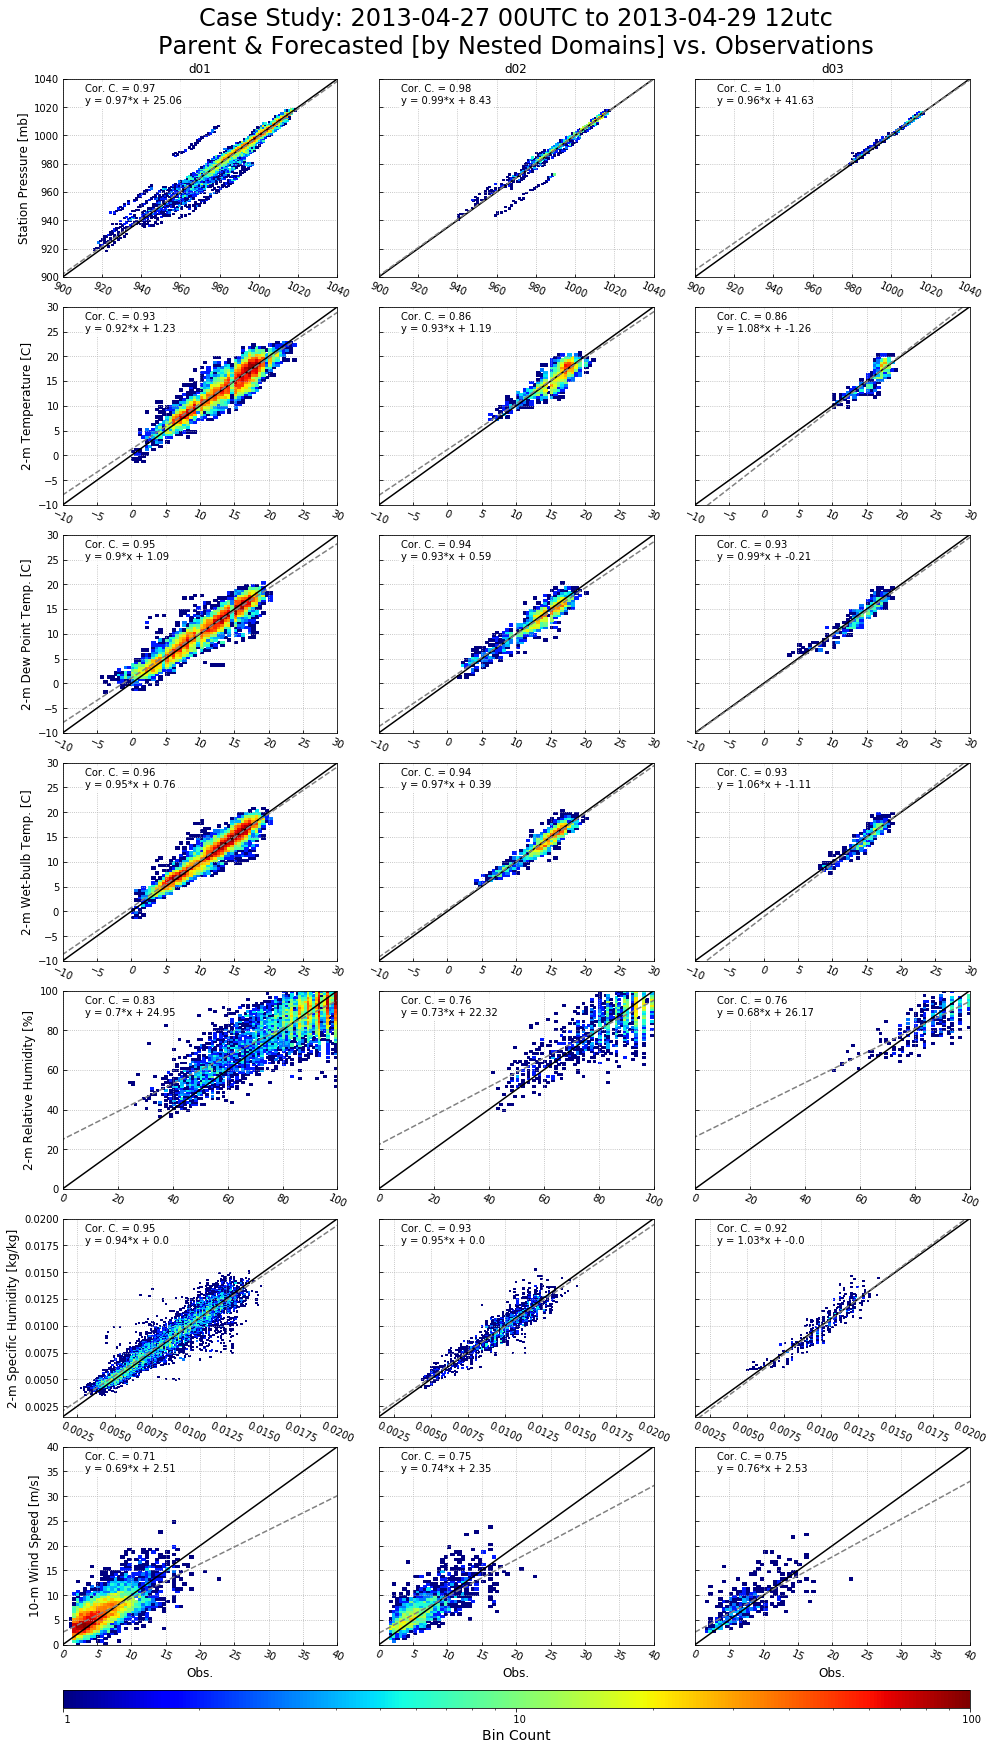

In [190]:
from matplotlib import pyplot as plt
from scipy import stats
from matplotlib import pyplot as plt
from scipy import stats
########################################################################################################################
### Constants
########################################################################################################################
LWIDTH = 1.5
trp = 0.8
CBAR_MAX = 100
line_x = np.arange(-100,200000)
ax_row = 1
ax_col = 4
fontszt = 12
fontsz = 12
RTT = -25
########################################################################################################################
### Join
########################################################################################################################
Domains  = ["d01","d02","d03"]
Obs      = pd.read_csv('20171028_20171030.csv')
NWP_path = 'C:/Users/Mike/Desktop/Offshore/Case_Studies/20171028/'
Event                    = 'XTREMEwx_'

Obs["Join_Array"] = ''
Concat   = np.empty((len(Obs), 1), dtype=object)
for i in range(len(Obs)):
    Concat[i,0] = str(Obs['Station'][i]) + "_"+str(Obs['Time_Valid'][i])
Obs["Join_Array"] = pd.DataFrame(Concat)
Obs['PSFC_o'] = Obs['PSFC_o']/100
    
fig = plt.figure(figsize=(14,25))
for y in range(len(Domains)):
    print(y)        
    d01_WRF  = pd.read_csv(NWP_path+'CaseStudy'+Domains[y]+'.csv')
    d01_WRF["Join_Array"] = ''
    d01_WRF['T2'] = d01_WRF['T2']-273.15
    d01_WRF['PSFC'] = d01_WRF['PSFC']/100
    Concat   = np.empty((len(d01_WRF), 1), dtype=object)
    for i in range(len(d01_WRF)):
        Temp_Date = datetime(d01_WRF['YYYY'][i],d01_WRF['MM'][i],d01_WRF['DD'][i],d01_WRF['HH'][i],0,0) 
        Concat[i,0] = str(d01_WRF['Station'][i])+"_"+YYYYMMDDHH_string(Temp_Date)
    d01_WRF["Join_Array"] = pd.DataFrame(Concat)
    Join = d01_WRF.merge(Obs, left_on='Join_Array', right_on='Join_Array')
    Print = Join[['Station_x','PSFC_o','T2_o','Td_o','WB_o','RH_o','SH_o','WS_o','PSFC'  ,'T2'  ,'Td'  ,'Tw'  ,'RH'  ,'SH'  ,'WS_10']]
    Print.to_csv(Event+"Join_"+Domains[y], sep=',')
########################################################################################################################
### Graphics
########################################################################################################################
    for x in range(7): # variables == row
        SUBPLOT = (y+x*3)+1
        if np.sum(np.isnan(np.asarray(Join['PSFC_o'])))!=len(Join['PSFC_o']):
            if SUBPLOT==1:
                #print("01")
                SUBPLOT = (y+x*3)+1
                ax = fig.add_subplot(nVars,nDomains,SUBPLOT)
                ax = plt.gca()
                Heat_bin_plots(XYMIN[x],XYMAX[x],INCR[x],Join[WRF_Array[x]],Join[Obs_Array[x]],c_min,c_max)
                ax.set_ylabel(Titles[x], fontsize = titlesize)
                ax.set_title(Domain[y], fontsize = titlesize)
                ax.tick_params(axis='both',direction='in')
                plt.grid(b=None, which='major', axis='both',linestyle=':')
            elif SUBPLOT==19:
                #print("03")
                SUBPLOT = (y+x*3)+1
                ax = fig.add_subplot(nVars,nDomains,SUBPLOT)
                ax = plt.gca()
                Heat_bin_plots(XYMIN[x],XYMAX[x],INCR[x],Join[WRF_Array[x]],Join[Obs_Array[x]],c_min,c_max)
                ax.set_ylabel(Titles[x], fontsize = titlesize)
                ax.set_xlabel(X_label, fontsize = fontszt)
                ax.tick_params(axis='both',direction='in')
                plt.grid(b=None, which='major', axis='both',linestyle=':')
            elif (SUBPLOT==4) | (SUBPLOT==7) | (SUBPLOT==10) | (SUBPLOT==13) | (SUBPLOT==16):
                #print("04")
                SUBPLOT = (y+x*3)+1
                ax = fig.add_subplot(nVars,nDomains,SUBPLOT)
                ax = plt.gca()
                Heat_bin_plots(XYMIN[x],XYMAX[x],INCR[x],Join[WRF_Array[x]],Join[Obs_Array[x]],c_min,c_max)
                ax.set_ylabel(Titles[x], fontsize = titlesize)
                ax.tick_params(axis='both',direction='in')
                plt.grid(b=None, which='major', axis='both',linestyle=':')
            elif (SUBPLOT==2) | (SUBPLOT==3):
                #print("04")
                SUBPLOT = (y+x*3)+1
                ax = fig.add_subplot(nVars,nDomains,SUBPLOT)
                ax = plt.gca()
                Heat_bin_plots(XYMIN[x],XYMAX[x],INCR[x],Join[WRF_Array[x]],Join[Obs_Array[x]],c_min,c_max)
                ax.set_title(Domain[y], fontsize = titlesize) 
                ax.set_yticklabels([])
                ax.tick_params(axis='both',direction='in')
                plt.grid(b=None, which='major', axis='both',linestyle=':')
            elif (SUBPLOT==20) | (SUBPLOT==21):
                #print("04")
                SUBPLOT = (y+x*3)+1
                ax = fig.add_subplot(nVars,nDomains,SUBPLOT)
                ax = plt.gca()
                Heat_bin_plots(XYMIN[x],XYMAX[x],INCR[x],Join[WRF_Array[x]],Join[Obs_Array[x]],c_min,c_max)
                ax.set_xlabel(X_label, fontsize = fontszt)
                ax.set_yticklabels([])
                ax.tick_params(axis='both',direction='in')
                plt.grid(b=None, which='major', axis='both',linestyle=':')
            else:
                    #print("05")
                SUBPLOT = (y+x*3)+1
                ax = fig.add_subplot(nVars,nDomains,SUBPLOT)
                ax = plt.gca()
                Heat_bin_plots(XYMIN[x],XYMAX[x],INCR[x],Join[WRF_Array[x]],Join[Obs_Array[x]],c_min,c_max)   
                ax.set_yticklabels([])
                ax.tick_params(axis='both',direction='in')
                plt.grid(b=None, which='major', axis='both',linestyle=':')
plt.suptitle("Case Study: 2013-04-27 00UTC to 2013-04-29 12utc"'\n'"Parent & Forecasted [by Nested Domains] vs. Observations"
             ,y=0.99,fontsize=24)
fig.subplots_adjust(bottom=0.08, top=0.95, left=0.05, right=0.95,
                    wspace=0.15, hspace=0.15)
#[left, bottom, width, height],
cb_ax = fig.add_axes([0.05, 0.045,0.9, 0.01])
cbar = fig.colorbar(dumby_img, cax=cb_ax,orientation="horizontal",format='%4.0f')
cbar.set_label('Bin Count',fontsize = 14)

In [204]:
Join[['WD_o','WD']]
counts, bin_edges = np.histogram(Join[['WD']], bins=np.arange(0,380,20))


array([  0,   0,   0,   0,   0,  69, 164,  71,  84,  61,  44,   5,  34,
        12,   0,   0,   0,   0], dtype=int64)

In [203]:
bins_range=np.arange(0,380,20)
bins_range

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360])